In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering

In [2]:
df = pd.read_pickle('cleaned_PrivCo_data.pkl')
print(df.info())
print(df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5997 entries, 0 to 5996
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PrivCo_ID               5997 non-null   int64  
 1   profile_type            5997 non-null   object 
 2   classification          5997 non-null   object 
 3   status                  5997 non-null   object 
 4   PE_Backed               5997 non-null   object 
 5   VC_Backed               5997 non-null   object 
 6   year_founded            5997 non-null   int64  
 7   City                    5948 non-null   object 
 8   State                   5933 non-null   object 
 9   Country                 5997 non-null   object 
 10  Zip                     4796 non-null   object 
 11  Industry_PICS           5980 non-null   object 
 12  Keywords                5812 non-null   object 
 13  sic                     201 non-null    object 
 14  naics                   564 non-null    

In [4]:
#deal with categorical data
#clean data
#turn into pickel
#train random forset model 
#use xgboost 
#compare
#start use variations of features to see what works best
#df.to_pickle('cleaned_PrivCo_data.pkl')


Drop anything that has NaN in the following columns : 
1 year rev growth - bc company is too new
1 year emplyee growth - bc company is too new

no don't do that



# Observations of data

- 3 year rev is CARG even if there are missing yeaars in between 
- 1 year rev growth is the CARG of last consectutive pair of non-null revenue

## For 2017 - 2023 Revenue,and EBITDA, I will combine each to get a non-null growth metric (for each metric used)
Ex: 2017 - 2023 Revenue contains companies that started in 2019 and only have 2019-2023 non-null revenue data. Therefor I will caluculate the companies Compound Anual Growth Rate (CAGR)


### 3-year Revenue growth is a good feature to use but it only has 1049 non-null values.

### I will create a new feture called CAGR (Compound Anual Growth Rate) using the revenue.

#### There are NaNs in the middle of Revenue data

Question: Why are there so many NaNs in the Revenue Growth Columns
- Companies haven't been around for 1 or 3 years?
- Growth can be calculated but isn't bc of missing values

In [5]:
df['year_founded'].value_counts()

2017    1768
2018    1506
2019    1082
2020     804
2021     544
2022     260
2023      33
Name: year_founded, dtype: int64

#### Check to see if any columns with NaN 3 year growth also have > 3 years of non-null data

In [6]:
#Create a df where all 3 Year Revenue Growth is NaN
null_df = df[df['3 Year Revenue Growth'].isna()]
#null_df = null_df[['2020 Revenue', '2022 Revenue']]

# Only want the revenue realted columns
null_df = null_df[['1 Year Revenue Growth',
       '3 Year Revenue Growth', '2023 Revenue', '2022 Revenue',
       '2021 Revenue', '2020 Revenue', '2019 Revenue', '2018 Revenue',
       '2017 Revenue']]

columns_to_check = ['2023 Revenue', '2022 Revenue', '2021 Revenue', 
                    '2020 Revenue', '2019 Revenue', '2018 Revenue', 
                    '2017 Revenue']

# For each row count the non-null values across the columns to check
non_null_counts = null_df[columns_to_check].notna().sum(axis=1)

# Get rows that have more than 3 non-null values in the specified columns
more_than_three = null_df[non_null_counts > 3]
more_than_three

1 Year Revenue Growth  3 Year Revenue Growth  2023 Revenue  \
142                 61.2376                    NaN           NaN   
700                134.1393                    NaN           NaN   
2341                    NaN                    NaN           NaN   
3719                    NaN                    NaN           NaN   
5574                11.7647                    NaN     5700000.0   

      2022 Revenue  2021 Revenue  2020 Revenue  2019 Revenue  2018 Revenue  \
142     14592000.0     9050000.0           NaN           0.0           0.0   
700     15493000.0     6617000.0           NaN           0.0           0.0   
2341           NaN           0.0           0.0           0.0           0.0   
3719           0.0           0.0           0.0           0.0           NaN   
5574     5100000.0     3650000.0           0.0           NaN           NaN   

      2017 Revenue  
142            NaN  
700            NaN  
2341           NaN  
3719           NaN  
5574           NaN

#### Lets check why 3719 has no revenue

In [7]:
# Checking why 3719 has no revenue
with pd.option_context('display.max_columns', None):  # Expands all columns
    display(df.iloc[3719:3720]) 


PrivCo_ID profile_type classification  status PE_Backed VC_Backed  \
3719    2122028      Company        Private  Active        No       Yes   

      year_founded      City State Country    Zip  \
3719          2019  New York    NY      US  10016   

                     Industry_PICS                             Keywords  sic  \
3719  Software & Internet Services  Community|SaaS|Workplace Management  NaN   

     naics Company_Tags  fiscal_month  fiscal_day  Total_Round  \
3719   NaN    VC Backed            12          31          4.0   

      index_total_funding  Latest_Valuation  Latest_Valuation_Year  \
3719          126310000.0       600000000.0                 2022.0   

      1 Year Revenue Growth  3 Year Revenue Growth  1 Year Employee Growth  \
3719                    NaN                    NaN                     NaN   

      3 Year Employee Growth  2023 Revenue  2022 Revenue  2021 Revenue  \
3719                     NaN           NaN           0.0           0.0   

      2020 Revenue  2019 Revenue  2018 Revenue  2017 Revenue  2023 Employees  \
3719           0.0           0.0           NaN           NaN             NaN   

      2022 Employees  2021 Employees  2020 Employees  2019 Employees  \
3719             NaN            40.0             NaN             NaN   

      2018 Employees  2017 Employees  2023 EBITDA  2022 EBITDA  2021 EBITDA  \
3719             NaN             NaN          NaN          NaN          NaN   

      2020 EBITDA  2019 EBITDA  2018 EBITDA  2017 EBITDA  2023 EV  2022 EV  \
3719          NaN          NaN          NaN          NaN      NaN      NaN   

      2021 EV  2020 EV  2019 EV  2018 EV  2017 EV  2023 Net Income  \
3719      NaN      NaN      NaN      NaN      NaN              NaN   

      2022 Net Income  2021 Net Income  2020 Net Income  2019 Net Income  \
3719              NaN              NaN              NaN              NaN   

      2018 Net Income  2017 Net Income  
3719              NaN              NaN

### Observation: Some companies are pre-revenue


Do I use CAGR or AAGR or 1 year rev growth or 3 year rev growth?

Use CAGR as it has time as a vaiable

If using CAGR, only non-zero revuenues as starting revenues bc you cannot divide by zero

# Function to calculate the CAGR for each row

#### If using CAGR, only non-zero revenues as starting revenues bc you cannot divide by zero
#### Remeber that some rows will have null entries in the middle of valid data

In [9]:
# Function to calculate CAGR 
def calculate_cagr(row):
    #print('')
    all_revenues = row[[f'{year} Revenue' for year in range(2023, 2016, -1)]] # Gather revenues for the row
    revenues = all_revenues.dropna() # Drops the NaNs

    # Check for at least two non-NaN revenues
    if len(revenues) < 2:
        #print("here 1")
        return np.nan
    #print(f'revenues: \n {revenues}')
    
    # Get the first non_NaN revenues
    v_final = revenues.iloc[0]
   
   # Loop through non-NaN revenues to find the first non-zero starting value
    v_begin = None    
    for index, revenue in revenues.iloc[::-1].items():
        if revenue > 0:
            v_begin = revenue
            begin_year = index.split(' ')[0]
           # print(f'begin_year: {begin_year}, revenue: {revenue}')
            break

    if v_begin is None:  # If all revenues are zero, return nan
        #print("here 2")
        return np.nan    
    
    
    final_year = revenues.index[0].split(' ')[0] # Get the year of the revenue value using the column name

    years_diff = int(final_year) - int(begin_year) # Get t, the difference of years between first and last rev
    
    #print(f' final_year: {final_year}, begin_year: {begin_year}, years diff: {years_diff}')
    # Calculate CAGR if years_diff is positive
    if years_diff > 0:
        cagr = ((v_final / v_begin) ** (1 / years_diff)) - 1
        return cagr
    else:
       # print("here 3")
        return np.nan

# Apply the function to each row (make copy of df first)
df['CAGR'] = df.apply(calculate_cagr, axis=1)

df


PrivCo_ID profile_type classification  status PE_Backed VC_Backed  \
0          4656      Company         Public  Active        No        No   
1         42154      Company        Private  Active        No        No   
2         45384      Company        Private  Active        No       Yes   
3         47579      Company        Private  Active        No        No   
4        268903      Company        Private  Active        No       Yes   
...         ...          ...            ...     ...       ...       ...   
5992    2141258      Company        Private  Active        No        No   
5993    2141302      Company        Private  Active       Yes       Yes   
5994    2141360      Company        Private  Active       Yes       Yes   
5995    2141394      Company        Private  Active        No        No   
5996    2141404      Company        Private  Active        No       Yes   

      year_founded           City State Country  ...     2018 EV     2017 EV  \
0             2020     Minnetonka    MN      US  ...         NaN         NaN   
1             2017   Cedar Rapids    IA      US  ...  63500000.0  56000000.0   
2             2017        Seattle    WA      US  ...         NaN         NaN   
3             2018        Houston    TX      US  ...         NaN         NaN   
4             2017  Mountain View    CA      US  ...         NaN         NaN   
...            ...            ...   ...     ...  ...         ...         ...   
5992          2018     Washington    PA      US  ...         NaN         NaN   
5993          2023       New York    NY      US  ...         NaN         NaN   
5994          2018  San Francisco    CA      US  ...         NaN         NaN   
5995          2020        Wichita    KS      US  ...         NaN         NaN   
5996          2021       New York    NY      US  ...         NaN         NaN   

     2023 Net Income 2022 Net Income 2021 Net Income 2020 Net Income  \
0                NaN     -27216000.0             NaN       -172000.0   
1          2550000.0       2800000.0       2900000.0             NaN   
2                NaN             NaN             NaN             NaN   
3           395000.0        395000.0             NaN             NaN   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
5992        365000.0        365000.0             NaN             NaN   
5993             NaN             NaN             NaN             NaN   
5994             NaN             NaN             NaN             NaN   
5995        205000.0        220000.0             NaN             NaN   
5996             NaN             NaN             NaN             NaN   

      2019 Net Income  2018 Net Income  2017 Net Income      CAGR  
0           6469000.0              NaN              NaN -0.185351  
1                 NaN              NaN              NaN -0.076999  
2                 NaN              NaN              NaN  0.128652  
3                 NaN              NaN              NaN  0.106061  
4                 NaN              NaN              NaN  0.100327  
...               ...              ...              ...       ...  
5992              NaN              NaN              NaN  0.111111  
5993              NaN              NaN              NaN       NaN  
5994              NaN              NaN              NaN       NaN  
5995              NaN              NaN              NaN  0.023810  
5996              NaN              NaN              NaN       NaN  

[5997 rows x 62 columns]

# Function to calculate the latest non-null EBITDA for each row

In [10]:
def calc_latest_EBITDA(row):
    #print('')
    all_ebitdas = row[[f'{year} EBITDA' for year in range(2023, 2016, -1)]] # Gather ebitdas for the row
    ebitdas = all_ebitdas.dropna() # Drops the NaNs
    
    #print(len(ebitdas))

    # Make sure thers's at least one non-NaN EBITDA
    if len(ebitdas) < 1:
        #print("nan")
        return np.nan
    #print(f'revenues: \n {revenues}')
    
    # Get first non_NaN ebitda
    latest_ebitda = ebitdas.iloc[0]
    #print(latest_ebitda)
    return latest_ebitda


df['Latest EBITDA'] = df.apply(calc_latest_EBITDA, axis=1)
df

# # Check
# with pd.option_context('display.max_columns', None):  # Expands all columns
#     display(df.iloc[0:1]) 


PrivCo_ID profile_type classification  status PE_Backed VC_Backed  \
0          4656      Company         Public  Active        No        No   
1         42154      Company        Private  Active        No        No   
2         45384      Company        Private  Active        No       Yes   
3         47579      Company        Private  Active        No        No   
4        268903      Company        Private  Active        No       Yes   
...         ...          ...            ...     ...       ...       ...   
5992    2141258      Company        Private  Active        No        No   
5993    2141302      Company        Private  Active       Yes       Yes   
5994    2141360      Company        Private  Active       Yes       Yes   
5995    2141394      Company        Private  Active        No        No   
5996    2141404      Company        Private  Active        No       Yes   

      year_founded           City State Country  ...     2017 EV  \
0             2020     Minnetonka    MN      US  ...         NaN   
1             2017   Cedar Rapids    IA      US  ...  56000000.0   
2             2017        Seattle    WA      US  ...         NaN   
3             2018        Houston    TX      US  ...         NaN   
4             2017  Mountain View    CA      US  ...         NaN   
...            ...            ...   ...     ...  ...         ...   
5992          2018     Washington    PA      US  ...         NaN   
5993          2023       New York    NY      US  ...         NaN   
5994          2018  San Francisco    CA      US  ...         NaN   
5995          2020        Wichita    KS      US  ...         NaN   
5996          2021       New York    NY      US  ...         NaN   

     2023 Net Income 2022 Net Income 2021 Net Income 2020 Net Income  \
0                NaN     -27216000.0             NaN       -172000.0   
1          2550000.0       2800000.0       2900000.0             NaN   
2                NaN             NaN             NaN             NaN   
3           395000.0        395000.0             NaN             NaN   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
5992        365000.0        365000.0             NaN             NaN   
5993             NaN             NaN             NaN             NaN   
5994             NaN             NaN             NaN             NaN   
5995        205000.0        220000.0             NaN             NaN   
5996             NaN             NaN             NaN             NaN   

     2019 Net Income  2018 Net Income  2017 Net Income      CAGR  \
0          6469000.0              NaN              NaN -0.185351   
1                NaN              NaN              NaN -0.076999   
2                NaN              NaN              NaN  0.128652   
3                NaN              NaN              NaN  0.106061   
4                NaN              NaN              NaN  0.100327   
...              ...              ...              ...       ...   
5992             NaN              NaN              NaN  0.111111   
5993             NaN              NaN              NaN       NaN   
5994             NaN              NaN              NaN       NaN   
5995             NaN              NaN              NaN  0.023810   
5996             NaN              NaN              NaN       NaN   

      Latest EBITDA  
0        -7000000.0  
1         3600000.0  
2               NaN  
3          562500.0  
4               NaN  
...             ...  
5992       517879.0  
5993            NaN  
5994            NaN  
5995       290000.0  
5996            NaN  

[5997 rows x 63 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5997 entries, 0 to 5996
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PrivCo_ID               5997 non-null   int64  
 1   profile_type            5997 non-null   object 
 2   classification          5997 non-null   object 
 3   status                  5997 non-null   object 
 4   PE_Backed               5997 non-null   object 
 5   VC_Backed               5997 non-null   object 
 6   year_founded            5997 non-null   int64  
 7   City                    5948 non-null   object 
 8   State                   5933 non-null   object 
 9   Country                 5997 non-null   object 
 10  Zip                     4796 non-null   object 
 11  Industry_PICS           5980 non-null   object 
 12  Keywords                5812 non-null   object 
 13  sic                     201 non-null    object 
 14  naics                   564 non-null    

# Still many NaN values so now I will try to impute the data

In [12]:
## Let start with using the following feature in our model: 3 Year Revenue Growth, 2021 Revenue, 2020 Revenue, 2019 Revenue, Latest EBITDA

In [13]:
# List of columns to impute
columns_to_impute = ['3 Year Revenue Growth', '2023 Revenue','2022 Revenue','2021 Revenue', '2020 Revenue', '2019 Revenue', 'Latest EBITDA']

# Calc the median for each column and replace NaNs with it
for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# # Calc the mean for each column and replace NaNs with it
# for column in columns_to_impute:
#     mean_value = df[column].mean()
#     df[column].fillna(mean_value, inplace=True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5997 entries, 0 to 5996
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PrivCo_ID               5997 non-null   int64  
 1   profile_type            5997 non-null   object 
 2   classification          5997 non-null   object 
 3   status                  5997 non-null   object 
 4   PE_Backed               5997 non-null   object 
 5   VC_Backed               5997 non-null   object 
 6   year_founded            5997 non-null   int64  
 7   City                    5948 non-null   object 
 8   State                   5933 non-null   object 
 9   Country                 5997 non-null   object 
 10  Zip                     4796 non-null   object 
 11  Industry_PICS           5980 non-null   object 
 12  Keywords                5812 non-null   object 
 13  sic                     201 non-null    object 
 14  naics                   564 non-null    

In [15]:
df.to_pickle('cleaned_PrivCo_data.pkl')

In [16]:
# Corlation matrix
plt.figure(figsize=(120,100))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 30})
plt.tick_params(axis='both', which='major', labelsize=40)
plt.show()

/var/folders/th/cpzn33tn2cbb3_fs33lld_2w0000gn/T/ipykernel_62892/1310308510.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


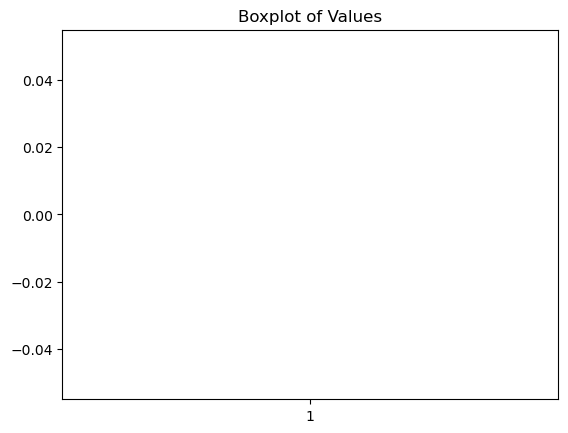

In [21]:
import matplotlib.pyplot as plt

# Boxplot
plt.boxplot(df['Latest_Valuation'])
plt.title("Boxplot of Values")

plt.show()